In [516]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
import math
import seaborn as sns
from scipy.stats import randint

In [517]:
teamname = "Arsenal"

matches = pd.read_csv("spi_matches.csv")
if(teamname == "all") :
    team_matches = matches
else :
    team_matches = matches[np.logical_or(matches['team1'] == teamname, matches['team2'] == teamname)]
team_matches_data = team_matches.loc[:, ['date', 'team1', 'team2', 'score1', 'score2', 'prob1', 'prob2', 'importance1', 'importance2', 'spi1', 'spi2']]

# Cleaning dataset and creating columns for team data 

In [530]:
for label, row in team_matches_data.iterrows() :
    print(str(row["date"]) + " : " + str(row["team1"]) + " " + str(row["score1"])[0] + "x"  + str(row["score2"])[0] + " " + str(row["team2"]))
    if(row['team1'] == teamname) :
        team_matches_data.loc[label, "goals_team"] = row['score1']
        team_matches_data.loc[label, "goals_adv"] = row['score2']
        team_matches_data.loc[label, "adv_team"] = row['team2']
        team_matches_data.loc[label, "place"] = "home"
        team_matches_data.loc[label, "prob_team"] = row['prob1']
        team_matches_data.loc[label, "spi_team"] = row['spi1']
        team_matches_data.loc[label, "spi_adv"] = row['spi2']
        team_matches_data.loc[label, "spi_dif"] = row['spi1'] - row['spi2']
        if(math.isnan(row['importance1'])) :
            team_matches_data.loc[label, "importance_team"] = 25.0
        else : 
            team_matches_data.loc[label, "importance_team"] = row['importance1']
        if(math.isnan(row['score1'])) :
            team_matches_data.loc[label, "goals_team"] = 0.0
            team_matches_data.loc[label, "goals_adv"] = 0.0
    else :
        team_matches_data.loc[label, "goals_team"] = row['score2']
        team_matches_data.loc[label, "goals_adv"] = row['score1']
        team_matches_data.loc[label, "adv_team"] = row['team1']
        team_matches_data.loc[label, "place"] = "away"
        team_matches_data.loc[label, "prob_team"] = row['prob2']
        team_matches_data.loc[label, "spi_team"] = row['spi2']
        team_matches_data.loc[label, "spi_adv"] = row['spi1']
        team_matches_data.loc[label, "spi_dif"] = row['spi2'] - row['spi1']
        if(math.isnan(row['importance2'])) :
            team_matches_data.loc[label, "importance_team"] = 25.0
        else :
            team_matches_data.loc[label, "importance_team"] = row['importance2']
        if(math.isnan(row['score1'])) :
            team_matches_data.loc[label, "goals_team"] = 0.0
            team_matches_data.loc[label, "goals_adv"] = 0.0

2016-08-14 : Arsenal 3x4 Liverpool
2016-08-20 : Leicester City 0x0 Arsenal
2016-08-27 : Watford 1x3 Arsenal
2016-09-10 : Arsenal 2x1 Southampton
2016-09-13 : Paris Saint-Germain 1x1 Arsenal
2016-09-17 : Hull City 1x4 Arsenal
2016-09-24 : Arsenal 3x0 Chelsea
2016-09-28 : Arsenal 2x0 Basel
2016-10-02 : Burnley 0x1 Arsenal
2016-10-15 : Arsenal 3x2 Swansea City
2016-10-19 : Arsenal 6x0 Ludogorets
2016-10-22 : Arsenal 0x0 Middlesbrough
2016-10-29 : Sunderland 1x4 Arsenal
2016-11-01 : Ludogorets 2x3 Arsenal
2016-11-06 : Arsenal 1x1 Tottenham Hotspur
2016-11-19 : Manchester United 1x1 Arsenal
2016-11-23 : Arsenal 2x2 Paris Saint-Germain
2016-11-27 : Arsenal 3x1 AFC Bournemouth
2016-12-03 : West Ham United 1x5 Arsenal
2016-12-06 : Basel 1x4 Arsenal
2016-12-10 : Arsenal 3x1 Stoke City
2016-12-13 : Everton 2x1 Arsenal
2016-12-18 : Manchester City 2x1 Arsenal
2016-12-26 : Arsenal 1x0 West Bromwich Albion
2017-01-01 : Arsenal 2x0 Crystal Palace
2017-01-03 : AFC Bournemouth 3x3 Arsenal
2017-01-14 :

# Creating data visualizations

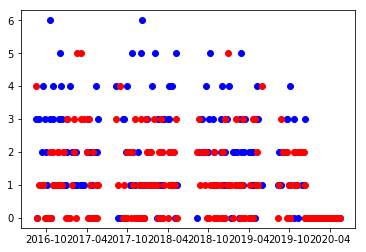

<Figure size 432x288 with 0 Axes>

In [531]:
team_matches_data.loc[:, "datetimeobj"] = team_matches_data.loc[:, "date"].apply(lambda x : datetime.datetime.strptime(x, "%Y-%m-%d"))

plt.plot_date(x=team_matches_data.loc[:, 'datetimeobj'], y=team_matches_data.loc[:,'goals_team'], xdate = True, ydate = False, color = 'blue')
plt.plot_date(x=team_matches_data.loc[:, 'datetimeobj'], y=team_matches_data.loc[:,'goals_adv'], xdate = True, ydate = False, color = 'red')
plt.show()
plt.clf()

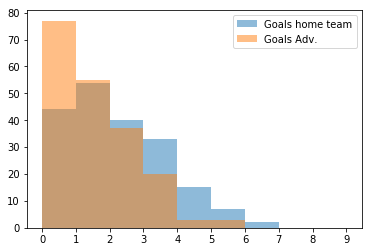

<Figure size 432x288 with 0 Axes>

In [532]:
plt.hist(team_matches_data['goals_team'], bins = range(10), alpha=0.5, label='Goals home team')
plt.hist(team_matches_data['goals_adv'], bins = range(10), alpha=0.5, label='Goals Adv.')
plt.legend(loc='upper right')
plt.xticks(range(10))
plt.show()
plt.clf()

# Training kNeighbors to predict goal numbers

In [540]:
team_done_matches = team_matches_data[team_matches_data['datetimeobj'] < datetime.datetime.now() - datetime.timedelta(days=1)]
team_predict = team_done_matches[['goals_team','prob_team', 'importance_team', 'spi_adv', 'place', 'spi_dif']]

team_predict = pd.get_dummies(team_predict, drop_First = True)

X = team_predict.drop('goals_team', axis=1).values
y = team_predict['goals_team'].values

#Discovering best parameter for k_neighbors
param_grid={'n_neighbors': np.arange(1,50)}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv = 5)

knn_cv.fit(X, y)

print(knn_cv.best_params_)
print(knn_cv.best_score_)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=knn_cv.best_params_['n_neighbors'])
knn.fit(X_train,y_train)
print("Predicted scores = ") 
print(knn.predict(X_test))
plt.hist(knn.predict(X_test), bins = range(10), alpha=1, label='Number of goals')
plt.xticks(range(10))
plt.show()
plt.clf()
print("\nPrecision of model = ") 
print(knn.score(X_test, y_test))
print("\nConfusion Matrix: ")
print(confusion_matrix(knn.predict(X_test), y_test))
print("\nClassification: ")
print(classification_report(knn.predict(X_test), y_test))

TypeError: get_dummies() got an unexpected keyword argument 'drop_First'

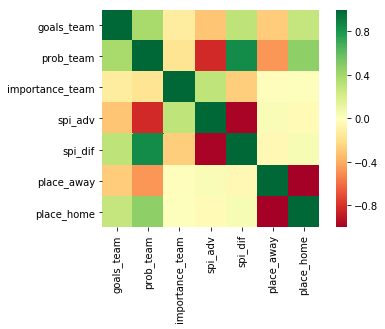

In [534]:
ax = sns.heatmap(team_predict.corr(), square=True, cmap='RdYlGn')
plt.show()

# Trying linear regression to predict goals

With one variable (prob_team first and spi_dif after)

0.1476973916848221


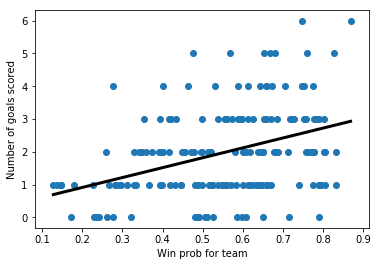

R^2: 0.33600488153076913
Root Mean Squared Error: 0.9728290228146107
[ 0.15340838  0.14882361  0.23740335  0.03589135 -0.10205584]


<Figure size 432x288 with 0 Axes>

In [535]:
reg = LinearRegression()

X = team_predict['prob_team'].values.reshape(-1,1)
y = team_predict['goals_team'].values.reshape(-1,1)

prediction_space = np.linspace(min(X), max(X)).reshape(-1,1)
reg.fit(X, y)
result = reg.predict(prediction_space)
print(reg.score(X,y))

# Plot regression line
plt.scatter(X,y)
plt.plot(prediction_space, result, color='black', linewidth=3)
plt.xlabel("Win prob for team")
plt.ylabel("Number of goals scored")
plt.show()
plt.clf()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print("R^2: {}".format(reg.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

cv_scores = cross_val_score(reg, X, y, cv=5)
print(cv_scores)

0.09701053181646824


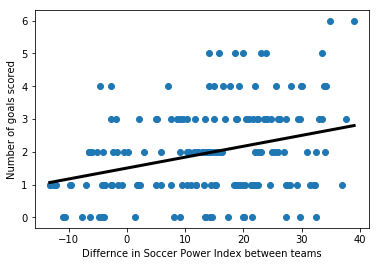

R^2: 0.19587425349210785
Root Mean Squared Error: 1.0705724402003607
[ 0.150661    0.09006867  0.10066665 -0.0284039  -0.04981854]


<Figure size 432x288 with 0 Axes>

In [536]:
reg2 = LinearRegression()

X = team_predict['spi_dif'].values.reshape(-1,1)
y = team_predict['goals_team'].values.reshape(-1,1)

prediction_space = np.linspace(min(X), max(X)).reshape(-1,1)
reg2.fit(X, y)
result = reg2.predict(prediction_space)
print(reg2.score(X,y))

# Plot regression line
plt.scatter(X,y)
plt.plot(prediction_space, result, color='black', linewidth=3)
plt.xlabel("Differnce in Soccer Power Index between teams")
plt.ylabel("Number of goals scored")
plt.show()
plt.clf()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
reg2.fit(X_train, y_train)
y_pred = reg2.predict(X_test)
print("R^2: {}".format(reg2.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

cv_scores = cross_val_score(reg, X, y, cv=5)
print(cv_scores)

Trying with all variables


Predictions

[2.69888244 1.60776144 1.84475974 0.85215785 1.4309532  2.21824159
 1.94769154 1.16748372 2.15752949 2.0672139  2.55890734 1.98320824
 1.02382906 2.15545725 0.82529472 2.55256312 1.68237906 1.89749574
 2.49525403 0.83178793 1.22394938 2.12917458 1.86594983 1.09491151
 1.88752378 1.87319338 2.02845631 1.0266999  1.58247625 1.30053902
 2.98184417 1.55973918 1.97764735 1.21690239 2.36381228]

Score

0.166462788218933

Coeficients

[-2.03397228e+00 -2.59667657e-04 -2.82061256e-02  2.60031664e-02
 -5.34542045e-01  5.34542045e-01]
4.589438657606297


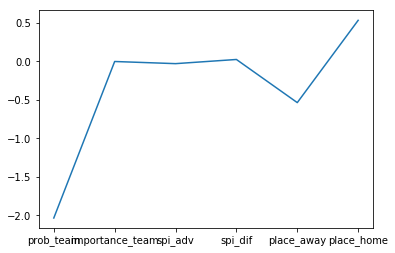

<Figure size 432x288 with 0 Axes>

In [537]:
reg_all = LinearRegression()

X = team_predict.drop('goals_team', axis = 1).values
y = team_predict['goals_team'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
reg_all.fit(X_train, y_train)
y_pred = reg_all.predict(X_test)

print("\nPredictions\n")
print(y_pred)
print("\nScore\n")
print(reg_all.score(X_test, y_test))
print("\nCoeficients\n")
print(reg_all.coef_)
print(reg_all.intercept_)

plt.plot(team_predict.drop('goals_team', axis = 1).columns, reg_all.coef_)
plt.show()
plt.clf()


# Logistic regression

In [538]:
X = team_predict.drop('goals_team', axis = 1).values
y = team_predict['goals_team'].values

#Choosing best parameter for model
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}
reg_log = LogisticRegression()
reg_log_cv = GridSearchCV(reg_log, param_grid, cv=5)
reg_log_cv.fit(X, y)

print("Melhor score com parametro = " + str(reg_log_cv.best_score_))
print(reg_log_cv.best_params_)

reg_log = LogisticRegression(C = reg_log_cv.best_params_['C'], penalty = reg_log_cv.best_params_['penalty'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
reg_log.fit(X_train, y_train)
y_pred = reg_log.predict(X_test)

print("\nPredictions\n")
print(y_pred)
print("\nPrecision of model = ") 
print(reg_log.score(X_test, y_test))
print("\nConfusion Matrix: ")
print(confusion_matrix(reg_log.predict(X_test), y_test))
print("\nClassification: ")
print(classification_report(reg_log.predict(X_test), y_test))

# Compute predicted probabilities: y_pred_prob
y_pred_prob = reg_log.predict_proba(X_test)[:,1]

adv_teams = team_done_matches['adv_team'].values

for i in range(y_pred_prob.shape[0]) :
    print("Previsão: " + str(int(y_pred[i])) + " gol(s) contra " + adv_teams[i] + " -> Confidence: " + str(y_pred_prob[i]))



C:\Program Files\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Melhor score com parametro = 0.3699421965317919
{'C': 0.4393970560760795, 'penalty': 'l1'}

Predictions

[3. 1. 3. 1. 1. 2. 2. 1. 2. 2. 2. 1. 1. 3. 1. 3. 2. 1. 2. 1. 1. 2. 2. 1.
 1. 2. 2. 1. 2. 1. 2. 1. 1. 1. 3.]

Precision of model = 
0.5142857142857142

Confusion Matrix: 
[[ 0  0  0  0  0  0]
 [ 2 10  2  0  2  1]
 [ 0  3  5  4  1  0]
 [ 0  1  1  3  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]]

Classification: 
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00         0
        1.0       0.71      0.59      0.65        17
        2.0       0.62      0.38      0.48        13
        3.0       0.43      0.60      0.50         5
        4.0       0.00      0.00      0.00         0
        5.0       0.00      0.00      0.00         0

avg / total       0.64      0.51      0.56        35

Previsão: 3 gol(s) contra Liverpool -> Confidence: 0.23021671221031512
Previsão: 1 gol(s) contra Leicester City -> Confidence: 0.32284960009465447
Previs

C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# Decision tree model

In [539]:
X = team_predict.drop('goals_team', axis = 1).values
y = team_predict['goals_team'].values


#Finding best parameters for Decision tree
# Setup the parameters and distributions to sample from: param_dist
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 6),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}
# Instantiate a Decision Tree classifier: tree
tree = DecisionTreeClassifier()
# Instantiate the RandomizedSearchCV object: tree_cv
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)
# Fit it to the data
tree_cv.fit(X,y)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

tree = DecisionTreeClassifier(criterion = tree_cv.best_params_['criterion'], max_depth = tree_cv.best_params_['max_depth'], max_features = tree_cv.best_params_['max_features'], min_samples_leaf = tree_cv.best_params_['min_samples_leaf'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

print("\nPredictions\n")
print(y_pred)
print("\nPrecision of model = ") 
print(reg_log.score(X_test, y_test))
print("\nConfusion Matrix: ")
print(confusion_matrix(reg_log.predict(X_test), y_test))
print("\nClassification: ")
print(classification_report(reg_log.predict(X_test), y_test))



Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 1, 'min_samples_leaf': 7}
Best score is 0.3583815028901734

Predictions

[1. 2. 1. 1. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 1.
 1. 2. 2. 1. 2. 2. 3. 1. 3. 2. 3.]

Precision of model = 
0.5142857142857142

Confusion Matrix: 
[[ 0  0  0  0  0  0]
 [ 2 10  2  0  2  1]
 [ 0  3  5  4  1  0]
 [ 0  1  1  3  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]]

Classification: 
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00         0
        1.0       0.71      0.59      0.65        17
        2.0       0.62      0.38      0.48        13
        3.0       0.43      0.60      0.50         5
        4.0       0.00      0.00      0.00         0
        5.0       0.00      0.00      0.00         0

avg / total       0.64      0.51      0.56        35



C:\Program Files\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
